In [1]:
# !pip install matplotlib
import matplotlib.pyplot as plt
import numpy as np
import diode
import dionysus as d
import json
import json
import operator
from numpy.random import choice
import csv
from datetime import date, timedelta
import datetime as dt
import matplotlib.dates as mdates
from scipy.ndimage.filters import uniform_filter1d


In [2]:
def sample_counties(date, x, weighted):
    with open('/Users/herbertwang/Duke 2024/Math 412/TDA-COVID-NC/Cases_By_County.json') as fp:
        json_data = json.load(fp)

        if not json_data.get(date) is None:
            countiesData = json_data[date]
        else:
            return None
        cases = []
        counties = []

        
        for key,values in countiesData.items():
            counties.append(key)
            if not weighted:
                cases.append(values[0])
            else:
                cases.append(values[2])
                #print(values[2])

        total = sum(cases)
        # print(total)
        for i in range(len(cases)):
            #print(cases[i])
            #print(total)
            cases[i] = cases[i] / total
            #print(cases[i])
    

        # print(cases)
        # for c in counties:
        #     cases.append(counties[c])
        list_of_counties = choice(counties, x, p= cases,replace=False)

        data = []
        with open("/Users/herbertwang/Duke 2024/Math 412/TDA-COVID-NC/County_Location.csv", encoding='utf-8-sig') as csvf:
            csvReader= csv.DictReader(csvf)
            for rows in csvReader:
                if rows['County'] in list_of_counties:
                    # print (rows)
                    data.append([float(rows['X']), float(rows['Y'])])

        data = np.asarray(np.stack(data))

        return data

In [3]:
def sample_section_counties(date, x, weighted, number):
    if number == 1:
        json_file_name = '/Users/herbertwang/Duke 2024/Math 412/TDA-COVID-NC/Cases_By_County.json'
    else:
        json_file_name = '/Users/herbertwang/Duke 2024/Math 412/TDA-COVID-NC/Cases_By_County_2.json'
    with open(json_file_name) as fp:
        json_data = json.load(fp)
        if not json_data.get(date) is None:
            countiesData = json_data[date]
        else:
            return None
    
        counties_list = {}
        for key,values in countiesData.items():
            if not weighted:
                counties_list[key] = values[0]
                # counties_list.append(tuple((key, values[0])))
            else:
                counties_list[key] = values[2]
                # cases.append(tuple((key, values[2])))
                #print(values[2])
        sorted_list = sorted(counties_list.items(), key=operator.itemgetter(1))
        sorted_list.reverse()
        #print(sorted_list)
        
        top_thirty = []
        mid_thirty = []
        last_thirty = []
        for i in range(len(sorted_list)-10):
            county, cases = sorted_list[i]
            if i<30:
                top_thirty.append(county)
            elif i<60:
                mid_thirty.append(county)
            else:
                last_thirty.append(county)
#         print(top_thirty)
#         print(len(top_thirty))
#         print(mid_thirty)
#         print(len(mid_thirty))
#         print(last_thirty)
#         print(len(last_thirty))

        data_top = []
        data_mid = []
        data_last = []
        with open("/Users/herbertwang/Duke 2024/Math 412/TDA-COVID-NC/County_Location.csv", encoding='utf-8-sig') as csvf:
            csvReader= csv.DictReader(csvf)
            for rows in csvReader:
                if rows['County'] in top_thirty:
                    data_top.append([float(rows['X']), float(rows['Y'])])
                    
                elif rows['County'] in mid_thirty:
                    data_mid.append([float(rows['X']), float(rows['Y'])])
                    
                elif rows['County'] in last_thirty: 
                    data_last.append([float(rows['X']), float(rows['Y'])])
#         print (data_top)
#         print (data_mid)
#         print (data_last)
        data_top = np.asarray(np.stack(data_top))
        data_mid = np.asarray(np.stack(data_mid))
        data_last = np.asarray(np.stack(data_last))

        return data_top, data_mid, data_last

In [4]:
def plot_counties(data):
    x_coords = []
    y_coords = []
    for x,y in data:
        x_coords.append(x)
        y_coords.append(y)
    x_fullcoords = []
    y_fullcoords = []
    with open("County_Location.csv", encoding='utf-8-sig') as csvf:
        csvReader= csv.DictReader(csvf)
        for rows in csvReader:
            # print (rows)
            x_fullcoords.append(float(rows['X']))
            y_fullcoords.append(float(rows['Y']))

    plt.style.use('seaborn-ticks')


    plt.scatter(x_fullcoords, y_fullcoords)
    plt.scatter(x_coords, y_coords)

    ax = plt.gca()
    ax.set_ylim([-90,-70])

    plt.show()

In [6]:
counties = sample_counties("11/7/21", 20, True)
print(counties)
plot_counties(counties)

None


TypeError: 'NoneType' object is not iterable

In [5]:
def calculate_total_homology(points):
    simplices = diode.fill_alpha_shapes(points)
    f = d.Filtration(simplices)
    m = d.homology_persistence(f)
    # for i,c in enumerate(m):
    #     print(i, c)

    dgms = d.init_diagrams(m, f)
    # print(dgms)
    zero_total_homology = 0
    first_total_homology = 0
    for i, dgm in enumerate(dgms):
        for pt in dgm:
            if i==0 and not pt.death == float("inf"):
                zero_total_homology+= ((pt.birth-pt.death)**2)
            if i==1:
                first_total_homology+= ((pt.birth-pt.death)**2)
            # print(i, pt.birth, pt.death)
    # print(zero_total_homology)
    # print(first_total_homology)
    
    return zero_total_homology, first_total_homology

In [6]:
def calculate_weighted_homology(date, number):
    data_coordinates = np.loadtxt("/Users/herbertwang/Duke 2024/Math 412/TDA-COVID-NC/County_Location2.csv", delimiter=',', usecols=range(1,3))
    lst1 = np.random.normal(0,1e-2, size = 100)
    data_3D = np.column_stack((data_coordinates,lst1))
    
    if number == 1 or number == 0:
        json_file_name = '/Users/herbertwang/Duke 2024/Math 412/TDA-COVID-NC/Cases_By_County.json'
    else:
        json_file_name = '/Users/herbertwang/Duke 2024/Math 412/TDA-COVID-NC/Cases_By_County_2.json'
    with open(json_file_name) as fp:
        json_data = json.load(fp)
        if not json_data.get(date) is None:
            countiesData = json_data[date]
        else:
            return None
    counties_weight = []
    
    for key,values in countiesData.items():
        if number ==0:
            counties_weight.append(values[0]/128)
        else:
            # print(key)
            counties_weight.append(values[2])
            # cases.append(tuple((key, values[2])))
            #print(values[2])
    data_3D_weighted = np.column_stack((data_3D,counties_weight))
    
    # print(data_3D_weighted)
    
    
    simplices = diode.fill_weighted_alpha_shapes(data_3D_weighted, exact=True)
    
    f = d.Filtration(simplices)
    # print(f)
    m = d.homology_persistence(f)
#     for i,c in enumerate(m):
#         print(i, c)

    dgms = d.init_diagrams(m, f)
    # print(dgms)
    zero_total_homology = 0
    first_total_homology = 0
    
    for i, dgm in enumerate(dgms):
        for pt in dgm:
            if i==0 and not pt.death == float("inf"):
                zero_total_homology+= ((pt.birth-pt.death)**2)
            if i==1:
                first_total_homology+= ((pt.birth-pt.death)**2)
                
                
            # print(i, pt.birth, pt.death)
    # print(zero_total_homology)
    # print(first_total_homology)
    
    return zero_total_homology, first_total_homology

In [15]:
print(calculate_weighted_homology("11/7/2021",0))

Filtration with 2153 simplices
[Diagram with 80 points, Diagram with 92 points, Diagram with 0 points, Diagram with 0 points]
(0.1597601111140819, 0.022845991354423216)


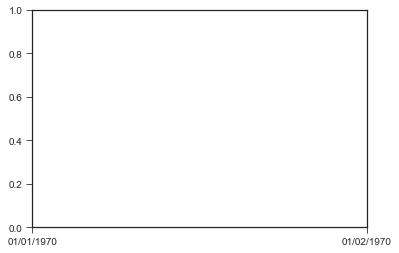

In [10]:
sdate = date(2021, 5, 20)   # start date
# sdate = date(2021, 10, 7)   # start date (test)
edate = date(2021, 11, 7)   # end date

delta = edate - sdate       # as timedelta
date_array_unformatted = []
zero_array = []
first_array = []
total_cases_array = []
total_deaths_array = []
for i in range(delta.days + 1):
    day = sdate + timedelta(days=i)
    day = day.strftime("%-m/%-d/%Y")
    total_county_sample = 12
    
    counties = sample_counties(day, total_county_sample, True)
    if not counties is None:
        date_array_unformatted.append(day)
        with open("/Users/herbertwang/Duke 2024/Math 412/TDA-COVID-NC/TABLE_DAILY_CASE&DEATHS_METRICS.csv", encoding='utf-16') as csvf:
            csvReader= csv.DictReader(csvf)
            for rows in csvReader:
                
                if dt.datetime.strptime(rows['Date'], '%m/%d/%y').strftime("%-m/%-d/%Y") == day:
                    total_cases_array.append(float(rows['Cases']))
                    total_deaths_array.append(float(rows['Deaths']))
    else:
        continue
    
    # print(counties)
    zero_total = 0
    first_total = 0
    total_trials = 30
    for j in range(total_trials):
        counties = sample_counties(day, total_county_sample, False)
        zero, first = calculate_total_homology(counties)
        zero_total+=zero
        first_total+=first
    zero_array.append(zero_total/total_trials)
    first_array.append(first_total/total_trials)
        
date_array = [dt.datetime.strptime(d,'%m/%d/%Y').date() for d in date_array_unformatted]
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m/%d/%Y'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=5))

In [11]:
N = len(zero_array)
zero_array_filtered = uniform_filter1d(zero_array, size=10)
first_array_filtered = uniform_filter1d(first_array, size=10)
total_cases_array_filtered = uniform_filter1d(total_cases_array, size=10)

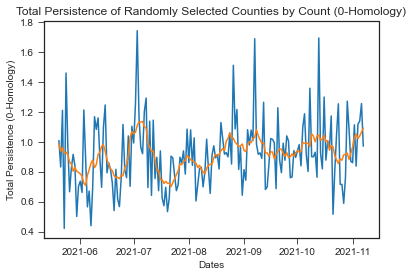

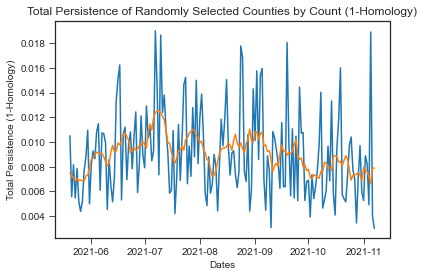

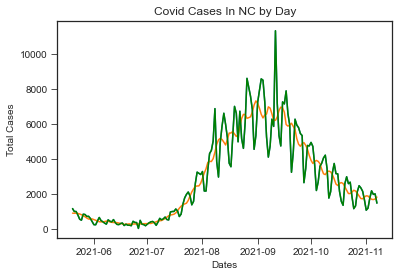

In [12]:
plt.style.use('seaborn-ticks')


plt.plot(date_array,zero_array)
plt.plot(date_array,zero_array_filtered)
plt.ylabel("Total Persistence (0-Homology)")
plt.xlabel("Dates")
plt.title("Total Persistence of Randomly Selected Counties by Count (0-Homology)")
plt.show()

plt.plot(date_array,first_array)
plt.plot(date_array,first_array_filtered)
plt.ylabel("Total Persistence (1-Homology)")
plt.xlabel("Dates")
plt.title("Total Persistence of Randomly Selected Counties by Count (1-Homology)")
plt.show()

plt.plot(date_array,total_cases_array)
plt.plot(date_array,total_cases_array_filtered)
plt.plot(date_array,total_cases_array, color = "green")
plt.ylabel("Total Cases")
plt.xlabel("Dates")
plt.title("Covid Cases In NC by Day")
plt.show()

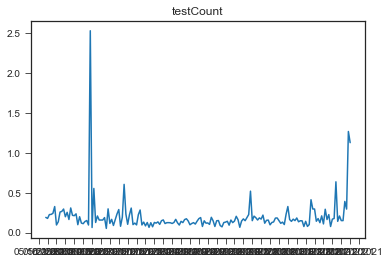

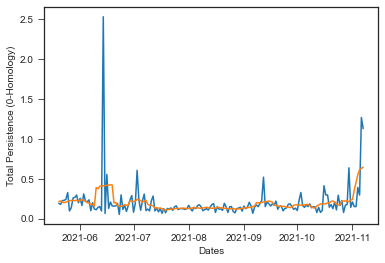

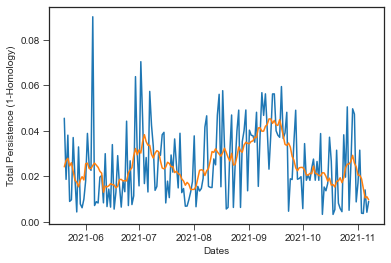

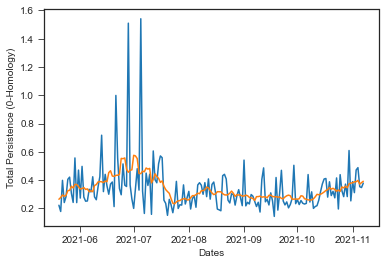

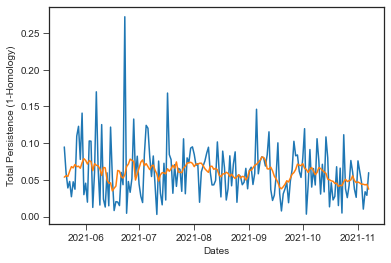

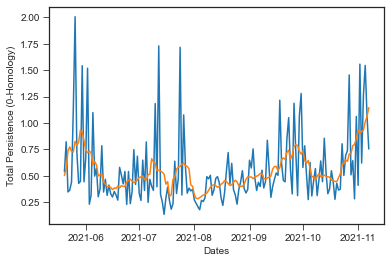

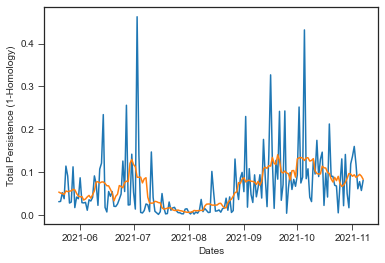

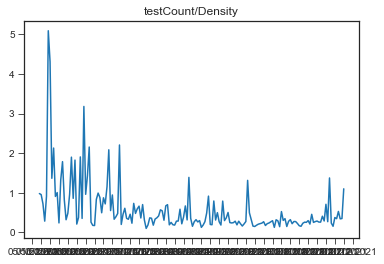

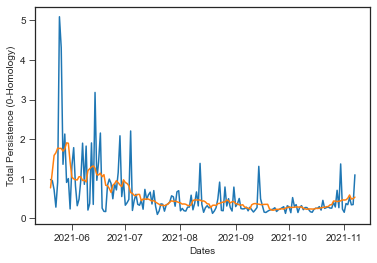

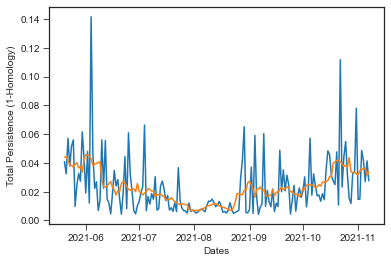

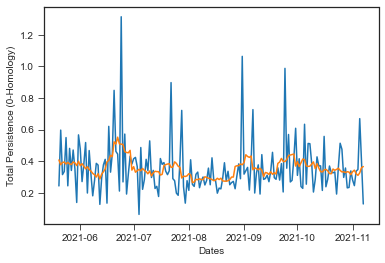

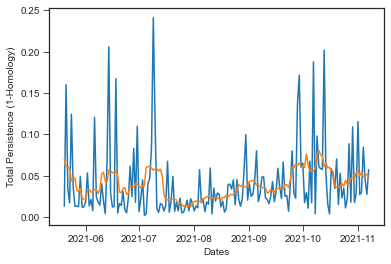

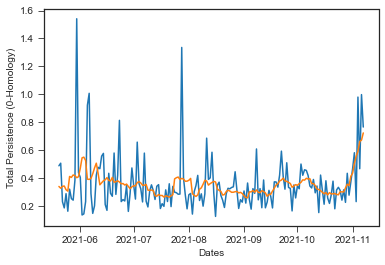

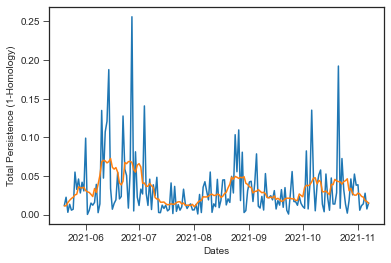

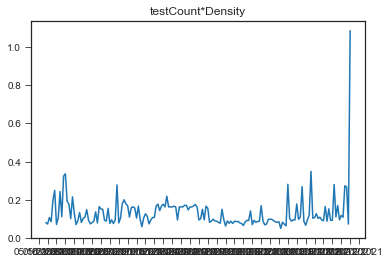

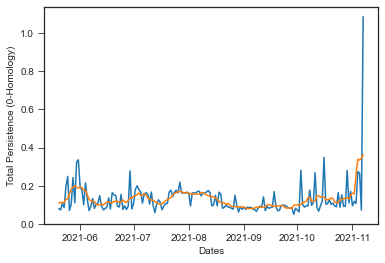

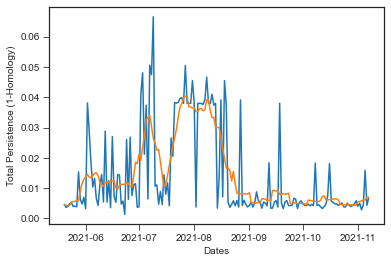

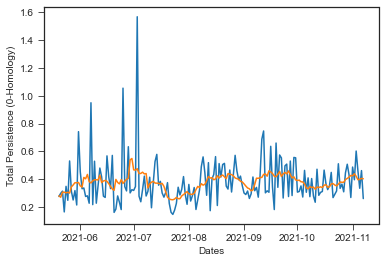

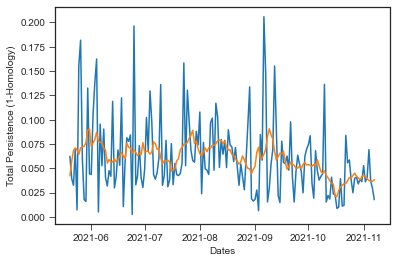

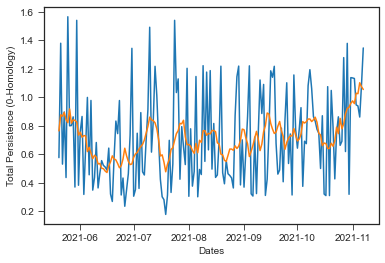

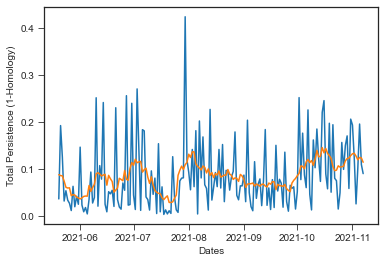

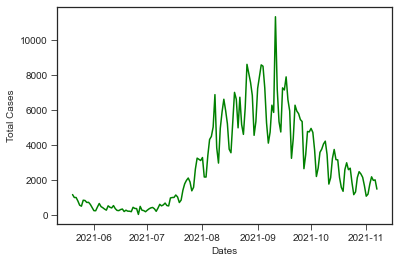

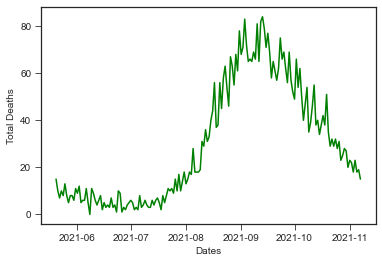

In [18]:
sdate = date(2021, 5, 20)   # start date
# sdate = date(2021, 10, 7)   # start date (test)
edate = date(2021, 11, 7)   # end date

delta = edate - sdate       # as timedelta
for j in range(3):
    date_array_unformatted = []
    zero_array_top = []
    zero_array_mid = []
    zero_array_last = []
    first_array_top = []
    first_array_mid = []
    first_array_last = []
    total_cases_array = []
    total_deaths_array = []
    for i in range(delta.days + 1):
        day = sdate + timedelta(days=i)
        day = day.strftime("%-m/%-d/%Y")
        total_county_sample = 50
        if j == 0:
            counties_top, counties_mid, counties_last = sample_section_counties(day, total_county_sample, False,1)
        else:
            counties_top, counties_mid, counties_last = sample_section_counties(day, total_county_sample, True, j)
        if not counties_top is None:
            date_array_unformatted.append(day)
            with open("/Users/herbertwang/Duke 2024/Math 412/TDA-COVID-NC/TABLE_DAILY_CASE&DEATHS_METRICS.csv", encoding='utf-16') as csvf:
                csvReader= csv.DictReader(csvf)
                for rows in csvReader:
                    if dt.datetime.strptime(rows['Date'], '%m/%d/%y').strftime("%-m/%-d/%Y") == day:
                        total_cases_array.append(float(rows['Cases']))
                        total_deaths_array.append(float(rows['Deaths']))
        else:
            continue

        # print(counties)
        

        zero_top, first_top = calculate_total_homology(counties_top)
        zero_mid, first_mid = calculate_total_homology(counties_mid)
        zero_last, first_last = calculate_total_homology(counties_last)

        zero_array_top.append(zero_top)
        zero_array_mid.append(zero_mid)
        zero_array_last.append(zero_last)
        first_array_top.append(first_top)
        first_array_mid.append(first_mid)
        first_array_last.append(first_last)

    date_array = [dt.datetime.strptime(d,'%m/%d/%Y').date() for d in date_array_unformatted]
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m/%d/%Y'))
    plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=5))
    
    position = ""
    if j == 0:
        position = "Count"
    elif j == 1:
        position = "Count/Density"
    else:
        position = "Count*Density"
        
    plt.plot(date_array,zero_array_top)
    plt.title("test" +position)
    plt.show()
    
    N = len(zero_array)
    zero_array_filtered = uniform_filter1d(zero_array_top, size=10)
    first_array_filtered = uniform_filter1d(first_array_top, size=10)
    plt.plot(date_array,zero_array_top)
    plt.plot(date_array,zero_array_filtered)
    plt.ylabel("Total Persistence (0-Homology)")
    plt.xlabel("Dates")
    #plt.title("Total Persistence of Top 30 Counties by "+ position+" (0-Homology)")
    plt.show()

    plt.plot(date_array,first_array_top)
    plt.plot(date_array,first_array_filtered)
    plt.ylabel("Total Persistence (1-Homology)")
    plt.xlabel("Dates")
    #plt.title("Total Persistence of Top 30 Counties by "+ position+" (1-Homology)")
    plt.show()
    
    zero_array_filtered = uniform_filter1d(zero_array_mid, size=10)
    first_array_filtered = uniform_filter1d(first_array_mid, size=10)
    plt.plot(date_array,zero_array_mid)
    plt.plot(date_array,zero_array_filtered)
    plt.ylabel("Total Persistence (0-Homology)")
    plt.xlabel("Dates")
    #plt.title("Total Persistence of Middle 30 Counties by "+ position+" (0-Homology)")
    plt.show()

    plt.plot(date_array,first_array_mid)
    plt.plot(date_array,first_array_filtered)
    plt.ylabel("Total Persistence (1-Homology)")
    plt.xlabel("Dates")
    #plt.title("Total Persistence of Middle 30 Counties by "+ position+" (1-Homology)")
    plt.show()
    
    zero_array_filtered = uniform_filter1d(zero_array_last, size=10)
    first_array_filtered = uniform_filter1d(first_array_last, size=10)
    plt.plot(date_array,zero_array_last)
    plt.plot(date_array,zero_array_filtered)
    plt.ylabel("Total Persistence (0-Homology)")
    plt.xlabel("Dates")
    #plt.title("Total Persistence of Last 30 Counties by "+ position+" (0-Homology)")
    plt.show()

    plt.plot(date_array,first_array_last)
    plt.plot(date_array,first_array_filtered)
    plt.ylabel("Total Persistence (1-Homology)")
    plt.xlabel("Dates")
    #plt.title("Total Persistence of Last 30 Counties by "+ position+" (1-Homology)")
    plt.show()

plt.plot(date_array,total_cases_array, color = "green")
plt.ylabel("Total Cases")
plt.xlabel("Dates")
plt.show()

plt.plot(date_array,total_deaths_array, color = "green")
plt.ylabel("Total Deaths")
plt.xlabel("Dates")
plt.show()



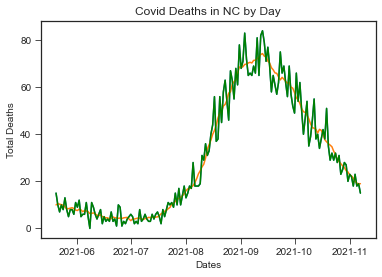

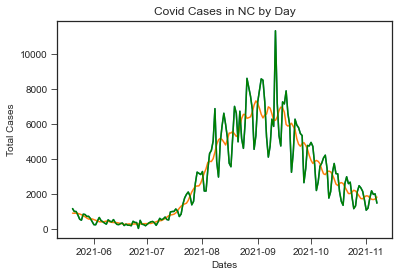

In [16]:

total_cases_array_filtered = uniform_filter1d(total_deaths_array, size=10)

plt.plot(date_array,total_deaths_array)
plt.plot(date_array,total_cases_array_filtered)
plt.plot(date_array,total_deaths_array, color = "green")
plt.ylabel("Total Deaths")
plt.xlabel("Dates")
plt.title("Covid Deaths in NC by Day")
plt.show()

total_cases_array_filtered = uniform_filter1d(total_cases_array, size=10)
plt.plot(date_array,total_cases_array)
plt.plot(date_array,total_cases_array_filtered)
plt.plot(date_array,total_cases_array, color = "green")
plt.ylabel("Total Cases")
plt.xlabel("Dates")
plt.title("Covid Cases in NC by Day")
plt.show()

Filtration with 2087 simplices
[Diagram with 58 points, Diagram with 57 points, Diagram with 0 points, Diagram with 0 points]
Filtration with 2023 simplices
[Diagram with 63 points, Diagram with 74 points, Diagram with 0 points, Diagram with 0 points]
Filtration with 2175 simplices
[Diagram with 79 points, Diagram with 86 points, Diagram with 0 points, Diagram with 0 points]
Filtration with 2215 simplices
[Diagram with 81 points, Diagram with 85 points, Diagram with 0 points, Diagram with 0 points]
Filtration with 1961 simplices
[Diagram with 56 points, Diagram with 61 points, Diagram with 0 points, Diagram with 0 points]
Filtration with 1915 simplices
[Diagram with 58 points, Diagram with 73 points, Diagram with 0 points, Diagram with 0 points]
Filtration with 2075 simplices
[Diagram with 63 points, Diagram with 62 points, Diagram with 1 points, Diagram with 0 points]
Filtration with 2031 simplices
[Diagram with 67 points, Diagram with 71 points, Diagram with 0 points, Diagram with 0 

Filtration with 1437 simplices
[Diagram with 21 points, Diagram with 11 points, Diagram with 0 points, Diagram with 0 points]
Filtration with 1455 simplices
[Diagram with 23 points, Diagram with 20 points, Diagram with 0 points, Diagram with 0 points]
Filtration with 1329 simplices
[Diagram with 21 points, Diagram with 18 points, Diagram with 0 points, Diagram with 0 points]
Filtration with 1277 simplices
[Diagram with 17 points, Diagram with 10 points, Diagram with 0 points, Diagram with 0 points]
Filtration with 1293 simplices
[Diagram with 22 points, Diagram with 16 points, Diagram with 0 points, Diagram with 0 points]
Filtration with 1293 simplices
[Diagram with 25 points, Diagram with 23 points, Diagram with 0 points, Diagram with 0 points]
Filtration with 1533 simplices
[Diagram with 27 points, Diagram with 26 points, Diagram with 0 points, Diagram with 0 points]
Filtration with 1123 simplices
[Diagram with 10 points, Diagram with 6 points, Diagram with 0 points, Diagram with 0 p

Filtration with 1645 simplices
[Diagram with 32 points, Diagram with 33 points, Diagram with 0 points, Diagram with 0 points]
Filtration with 1855 simplices
[Diagram with 36 points, Diagram with 39 points, Diagram with 0 points, Diagram with 0 points]
Filtration with 1417 simplices
[Diagram with 15 points, Diagram with 11 points, Diagram with 0 points, Diagram with 0 points]
Filtration with 1275 simplices
[Diagram with 19 points, Diagram with 14 points, Diagram with 0 points, Diagram with 0 points]
Filtration with 1491 simplices
[Diagram with 22 points, Diagram with 15 points, Diagram with 0 points, Diagram with 0 points]
Filtration with 1591 simplices
[Diagram with 24 points, Diagram with 14 points, Diagram with 0 points, Diagram with 0 points]
Filtration with 1295 simplices
[Diagram with 24 points, Diagram with 14 points, Diagram with 0 points, Diagram with 0 points]
Filtration with 1905 simplices
[Diagram with 44 points, Diagram with 44 points, Diagram with 0 points, Diagram with 0 

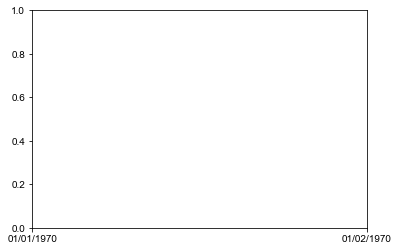

In [16]:
sdate = date(2021, 5, 20)   # start date
# sdate = date(2021, 10, 7)   # start date (test)
edate = date(2021, 11, 7)   # end date

delta = edate - sdate       # as timedelta
date_array_unformatted = []
zero_array = []
first_array = []
total_cases_array = []
total_deaths_array = []
for i in range(delta.days + 1):
    day = sdate + timedelta(days=i)
    day = day.strftime("%-m/%-d/%Y")
    zero, first = calculate_weighted_homology(day, 0)
    if not zero is None:
        zero_array.append(zero)
        first_array.append(first)
        date_array_unformatted.append(day)
    
date_array = [dt.datetime.strptime(d,'%m/%d/%Y').date() for d in date_array_unformatted]
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m/%d/%Y'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=5))

N = len(zero_array)
zero_array_filtered = uniform_filter1d(zero_array, size=10)
first_array_filtered = uniform_filter1d(first_array, size=10)

plt.style.use('seaborn-ticks')







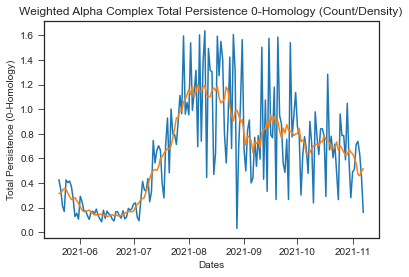

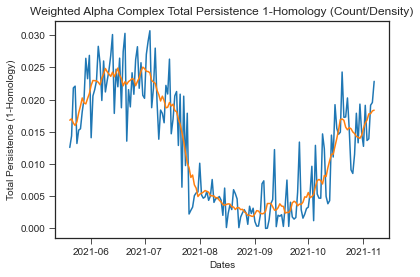

In [18]:
plt.plot(date_array,zero_array)
plt.plot(date_array,zero_array_filtered)
plt.ylabel("Total Persistence (0-Homology)")
plt.xlabel("Dates")
plt.title("Weighted Alpha Complex Total Persistence 0-Homology (Count/Density)")
plt.show()

plt.plot(date_array,first_array)
plt.plot(date_array,first_array_filtered)
plt.ylabel("Total Persistence (1-Homology)")
plt.xlabel("Dates")
plt.title("Weighted Alpha Complex Total Persistence 1-Homology (Count/Density)")
plt.show()